### Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

> This is prepared for Udacity Machine Learning Engineer Nanodegree online class  
Author: jtmoogle @github.com All Rights Reserved   
Date: Aug-Sept 30, 2017  


Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

>The following steps were performed
1. Understand the World
2. Understand the Code
3. Implement a Basic Driving Agent
    - Basic Agent Simulation Results
4. nform the Driving Agent
    - Define a State Space
    - Update the Driving Agent State
5. Implement a Q-Learning Driving Agent
    - Q-Learning Simulation Results
    - Define an Optimal Policy
    - Optional: Future Rewards - Discount Factor, 'gamma'

In [1]:
# Import the visualization code
import sys 
from platform import python_version
import visuals as vs
from IPython.display import display # Allows the use of display() for DataFrames
from platform import python_version
print( '--> sys version= {} '.format(sys.version ))
print( '--> python version= {}'.format(python_version()))

# Pretty display for notebooks
%matplotlib inline

verbos=False

--> sys version= 2.7.13 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:17:26) [MSC v.1500 64 bit (AMD64)] 
--> python version= 2.7.13


### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
1. *Does the Smartcab move at all during the simulation?*
2. *What kind of rewards is the driving agent receiving?*
3. *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
or
'runsmart -c 1 > logs\logs-c1.txt`  #1 : if running "no learning"  (for question 2)
'runsmart -c 2 > logs\logs-c2.txt`  #2 : if running "default learning"  (for question 5)
'runsmart -c 3 > logs\logs-c3.txt`  #3 : if running "improved learning" (for question 6)
'runsmart -c 9 > logs\logs-c9.txt`  #9 : running 1 -> 2 -> 3 in sequencial order
```

>**Answer:**  
The first simulation was used the DEFAULT values describing below:

>|learning|enforce_deadline|epsilon|alpha|n_dummies| grid_size|tolerance|testing trial simulated|update delay|optimized|
| :--: |:--:|:--:|:--:|:--:| :--:|:--:|:--:|:--:|
|false|false| 1.0|0.5|100|(8, 6)|0.05|10|0.01|false|

>1. I observed that the driving smartcab moved few blocked and stopped during the simulation.  The stopped could be idle at red light, or idled at a green light with no oncoming traffic, or bad actions cause accidents
2. + The agent received (negative) decreased rewards when having bad actions or violation such as
    - drove forward through a red light
    - caused major or minor accident
    - being idle at a green light with no oncoming traffic
   + The agent got (positive) increased rewards when having good actions such as
    - turned right at a red light when no traffic at right/left/oncoming traffic
    - headed forward at a green light 
    - being idle at a red light
    - turned left at a green light when no traffic at right, left or oncoming path
3. My observation was that the rewards did not have significant changes affected by the light changing color.  
But, if adding 'violation count' along with light changing color, I saw rewards changes as follows: 
    - if changing green light to red light
        - If no violation, got increased (positive) rewards
        - If violation count > 0, got decreased (negative) rewards.  More change to see violation count > 0
        - If major accident, large negative rewards
    - if changing red light to green light
        - if no violation, got increased rewards
        - if violation count > 0, got decreased (negative) rewards

>| changing light color | Violation Count | Rewards | Note |
| --------- | :---: | :----| :---- |
| Red -> Green <br> Green -> Red | > zero | Get decreased (negative) rewards | The more violation count The less rewards received |
| Red -> Green <br> Green -> Red | = zero | Get increased (positive) rewards | The zero violation The more rewards received |


### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
1. In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
2. *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
3. *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
4. *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

>**Answer:**  
1. In agent.py, I could configured the driving agent with associated parameters 
    - Toggle 'learning' value: TURE/FALSE indicating if the driving agent was in the learning or no-learning mode.  Default to FALSE.  
        - if TRUE, the agent would use Q-learning technique to find an optimal action-selection policy for any given (finite) Markov decision process (MDP).
        - if FALSE, the agent would use random action-selection
    - Set 'epsilon' value: a float indicating random exploration factor, default to 1.0.  
        - if value was between previous learning and risk-taking, the better
        - Note:
            - if too low, the agent would not learn new behavior because consistently in the 'SAFE' condition or using previous learnings
            - if too higher, the agent would keep learning new behavior, and taking risks consistently.  The higher randomness the higher exploration
            - if zero, the agent would explore all the actions in as few steps as possible, being a pure exploiter
    - Set 'alpha' value: a float showing learning factor, how much the agent is going to learn, default to 0.5
        - if value between 0 and 1.0, the better to enhance new learning on top of previous learning
            - Generally, 0 < alpha < 1.0    
            - Example: 0.5 constant learning rate:  alpha(state, action) = 0.5 for all t(rial)
        - Note:
            if zero, no new learning, reuse previous learning, behave as usual
            if one, no inheritance algorithm from previous learning, consistent new learning 
2. In environment.py, the 'act' function of environment class was called to perform the action, and would receive a reward for good action based on traffic law.
3. In simulator.py, 
    - 'render_text' function was called to render the simulated trial data output in non-GUI display such as terminal/command prompt.  
    - 'render' function was called to render and display simulated trial data output in GUI display/interface.
4. In planner.py, the next_waypoint function was called and conducted the following checks  
    - (1) if the destination location was at this location
    - (2) if the agent's heading direction to the destination was East or West direction, 
    - (3) if the agent's heading direction was North or South to destination


-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of 
- 'None'  (do nothing) 
- 'left'  (turn left), 
- 'right' (turn right), 
- 'forward' (go forward). 

For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


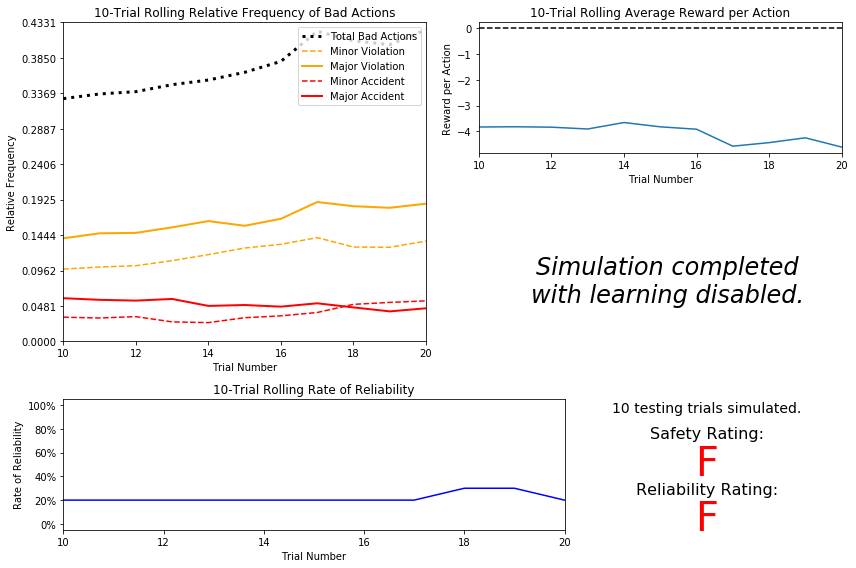

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
1. *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
2. *Given that the agent is driving randomly, does the rate of reliability make sense?*
3. *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
4. *As the number of trials increases, does the outcome of results change significantly?*
5. *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

>**Answer:**
The initial simulation with no learning and simple random action had 'F' safety and Reliability ratings.  
From visualization, my observation described in the below matrix and sorted by relative frequencies percentage

>|Topic Focused| Basic Driving Agent relative frequencies |
| :---------| :------------ |
| Total bad actions | 33% increased to 43%|
| Major violation | 14% increased to 18% |
| Minor violation|  9% slightly increased to 13% |
| Major accidents | 5% decreased to 4% |
| Minor accidents | ~4% | 
|
>1. The driving agent made bad decision started high frequency 33%, went up to 43% at the end trial 18.  Major accident had approx. 4-5%
2. The driving agent drove randomly, no learning, the reliability rating illustrated 20%, slightly went up to 30% at trail 17-18.  It made sense to rank F because the driving agent DID 80% (100-20%) fail to reach destination on time.
3. The driving agent got negative rewards starting negative 5% because over 40% bad decision causing accidents and violations.  The rewards slight went down closing to negative 5.5% at trail number 15 to 17 as bad action increased to 42%.  
    - Major accidents (violation:4) penalized/decreased rewards -40 attempted driving forward through a red light with traffic and cause a major accident
    - Minor accidents (violation:3) penalized/decreased rewards -20 attempted driving right through traffic and cause a minor accident
    - Major violation (violation:2) penalized/decreased rewards -10 attempted driving left through a red light; attempted driving forward through a red light
    - Minor violation (violation:1) penalized/decreased rewards -5 idled at a green light with no oncoming traffic
4. As number of trials increased, outcome of result had no significantly change
5. I would consider this smart cab not reliable neither safe, nor no learning at this moment.  It caused many major accident, such as driving through a red light, and 80% (100-20%) failed to reach the destination on time.


-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
1. Which features available to the agent are most relevant for learning both **safety** and **efficiency**? 
2. Why are these features appropriate for modeling the *Smartcab* in the environment? 
3. If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.

NOTE: You are not allowed to engineer new features for the smartcab. 

>**Answer:**
1.The following table listed input features which were relevant to safety & efficiency consideration

>| Evaluation for | More Relevant<br>Input Features | Less Relevant<br> Features |
|:----: | :------------------------------ | :-- |
| Safety | (1) traffic `'Light'` representing state of traffic <br> (2) `'Left'` traffic direction <br>(3) `'Oncoming'` traffic direction | (1) `'Right'` traffic direction | 
| Efficiency | (1) `'Next waypoint'` indicating the direction of waypoint toward destination | (1) Count of remaining `'deadline'` action to destination | 

>2.I would choose above more relevant features to model the smartcab in the environment.  They were appropriately used to determine intersection state and traffic action.  
- Safety: features of light state, left traffic direction, oncoming traffic direction would avoid/reduce traffic accidents or/and violations
- Efficiency: feature of next waypoint could help driving agent to avoid/reduce mistakes or longer distances to reach destination 

        
>See examples of use cases

>| # |Use cases for Safety | logics translation | 
   | -- | :------------------- | :-------------------------------- |
   | UC_1.0 |If green light, the driving agent should be **SAFE** | if light=green  |
   | UC_1.1 |(1) go forward | action=forward |
   | UC_1.2 |(2) turn right | action=right |
   | UC_1.3 |(3) Yield (wait) for any oncoming traffic <br>which would go straight or turn right,| and if oncoming=forward or right, action=Wait|
   | UC_1.4| (4) before turn left | and if oncoming=left, action=left |
   | UC_2.0 | If red light, the agent should be **SAFE** | if light=red |
   | UC_2.1 | (1) Yield(wait) for any oncoming traffic <br>which would go straight, | and if oncoming=forward, action=Wait |
   | UC_2.2 | (2) before turn right | and if oncoming=right or left, action=right |

>3.I did not choose the less relevant features 
- `'Right'` traffic direction would not provide significant help on the red or green light state.  It is ok not including this feature, it wouldn't affect the agent driving experience.  
    - If red light, the agent should stop, not action taken.  
    - If green, the driving agent would still go forward because the right traffic should stop at their end.  
- Count of remaining `'deadline'` actions to destination would NOT significant impacting the driving agent action decision and  shorten the agent movement.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, 
1. what would be the size of the state space? 
2. Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

>**Answer:**
1.The matrix showed my chosen features, possible values and number of valid values.  

>| My Chosen Features | Possible values | Count of possible values |
| :---------- | :----------- | :-----: |
| Traffic light | true/ false (interpret as green/red) |2 valid states |
| Oncoming traffic | forward/ left/ right/ None |4 valid actions| 
| Left traffic | forward/ left/ right/ None |4 valid actions | 
| Next waypoint | forward/ left/ right/ None <sup>note 1</sup> | 4 valid actions | 

><small>[note1]: The next_waypoint function in planner.py, would return states ('forward', 'left', 'right', 'None')   'None' indicated if the agent arrived the destination. I'd like to note that I haven't found 'None' for next_waypoint in actual log files yet.   </small>

>My calculation for size of state space, pair (state, action) would be `'2 x 4 x 4 x 4 = 128'` 


>2.The environment was configured with associated parameters

>|learning|enforce_deadline|epsilon|alpha|n_dummies| grid_size|tolerance|testing trial simulated|update delay|optimized|
| :--: |:--:|:--:|:--:|:--:| :--:|:--:|:--:|:--:|
|false|false| 1.0|0.5|100|(8, 6)|0.05|10|0.01|false|

> When simulation was started, the following executed in the sequence orders
- Initiation - constructed class with parameter values
    1. Created an environment with default values: 100 dummy drivers, (8,6) grid_size for road network
    2. Created a driving agent no using Q-learning, epsilon-exploration factor to 1, alpha-learning rate to 0.5 
    3. followed the driving agent, not enforce a deadline metric
    4. Created a simulator setting continuous time in 0.01 seconds, enabling the PyGame GUI, no log trial and simulation result to log file, no optimized.
    Simulation
- Ran a simulation of the environment 
    - The primary agent performed 10 testing trials simulated, 0.05 for epsilon tolerance before beginning testing
    - If no learning, it simulated 20 training trials, and followed 10 testing trials 
    - If learning was enabled, the simulator would explore the action (1) build current state value (2) create 'state' in a Q-table (3) choose a random action or get max Q-value of all actions (4) receive a current reward (5) update learning rate
                Number of trial would be 128+, possible values of the features.  
    
>- As iterating each training or testing trail
    1. The simulated environment would be reset at the beginning 
    2. Executed time step of simulation.  
        - Primary agent and other agents updated involved as follows
            + Building the agent state 
            + Choosing an action: either getting random action with epsilon probability, or choosing maximum Q-value of all actions based on 'state' the agent was in
            + Receiving a reward
            + Conducting learning Q-value= current Q-value * (1-alpha) + alpha * (current reward + discount factor <del>* expected future reward</del>)
            + Checking condition if hit hard time limit, or ran out of time.  If yes, aborted trial.
        - update states of intersection lights and traffic
        - Since action was taken, reduced deadline count
    3. Calculated timing, and collected metric from trial 
    
> The simulator would learn a policy by building up to 128 combined states in Q-table, recording rewards, final deadline, action taken, and success indicator to reach destination.
          

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: 
- For every state the agent visits, create an entry in the Q-table for all state-action pairs available. 
- Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. 
- Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. 
    
For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. 

Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

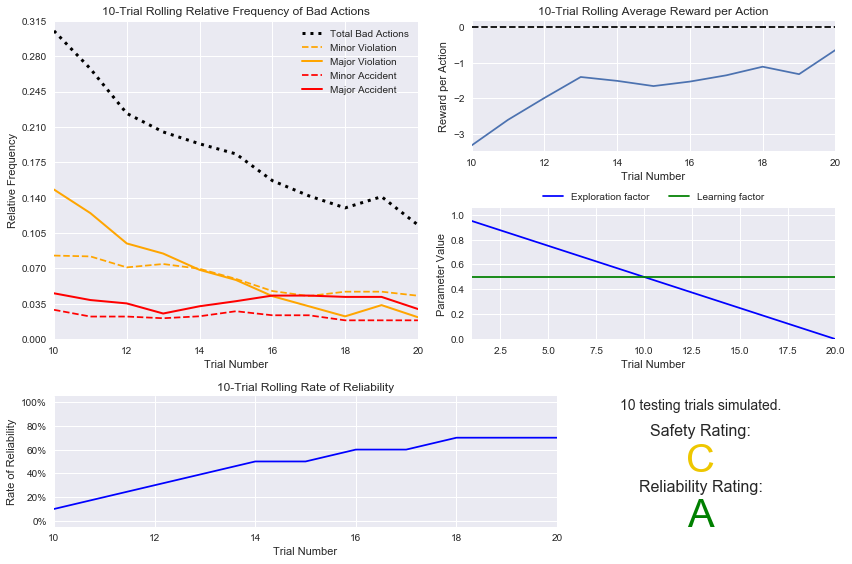

In [11]:

# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
1. *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
2. *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
3. *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
4. *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
5. *How does the safety and reliability rating compare to the initial driving agent?*

>**Answer:**
The environment was configured with associated parameters for Q-learning agent 

>|learning|enforce_deadline|epsilon|alpha|n_dummies| grid_size|tolerance|testing trial simulated|update delay|optimized|
| :--: |:--:|:--:|:--:|:--:| :--:|:--:|:--:|:--:|
|True|True| 1.0|0.5|100|(8, 6)|0.05|10|0.01|false|

> Extended question 3 result with Q-learning agent relative frequencies

>|Topic Focused| Basic Driving Agent frequencies | Default Q-learning Agent frequencies| 
| :---------| :---------- | :----------------- |
| Total bad actions | 33% increased to 43%| 31% went down to 12% |
| Major violation | 14% went down 19% at trial 18 | 14% went down to 2%|
| Minor violation| 9% slightly increased to 13% | 8% went down below 5%|
| Major accidents | 5% decreased to 4% | 5% slightly decreased to 3% |
| Minor accidents | ~4% | ~3% went down to 2% |


>| Question | Basic Driving Agent | Default Q-learning Agent|
| :------- |   :------------------| :--------------- |
|Q1. Observation for similarity | (1) sequence order of bad actions <br> rewards % per action | (1) sequence order of bad actions first 20 trials <br> reward % per action |
|Q2.1 training trials before testing | 20 training trials 10 testing | 20 training 10 testing |  
|Q2.2 make sense given epsilon-tolerance | no learning, drove randomly| make sense given epsilon-tolerance $\epsilon$(t+1) = $\epsilon$(t) - 0.05, default was 1, decay subtraction from 0.05, after 20 trial, epsilon was close to 0 | 
|Q3. Decaying function $\epsilon$  | learning was disabled, couldn't compare | yes, The parameter panel graph matched the exploration factor starting at 1.0 decaying/subtracting 0.05, it was close to zero at trial 20. |
|Q4. As number of trial increase, bad action? | Increased 10% range | significantly decreased 20% range | 
|Q5. Safety and reliability rating comparison| F<br>F<br>| C<br>A <br> |

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

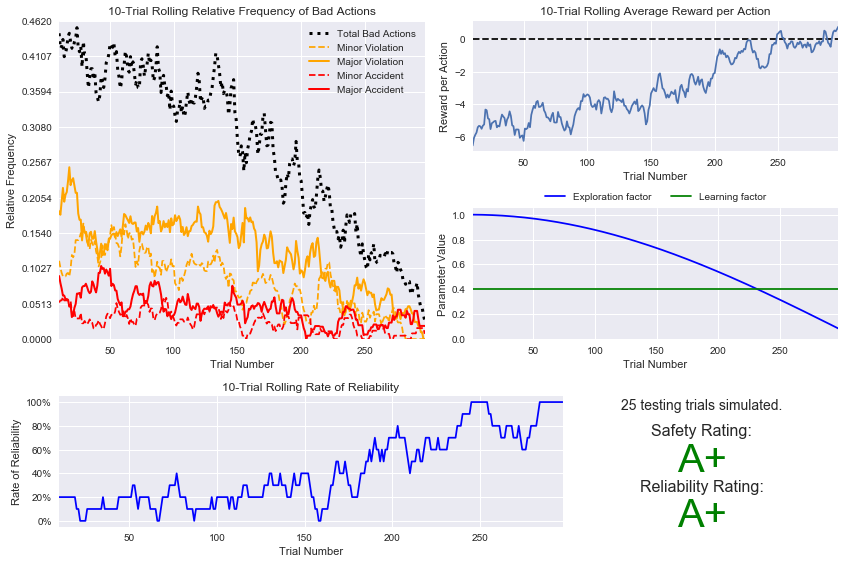

In [19]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
1. *What decaying function was used for epsilon (the exploration factor)?*
2. *Approximately how many training trials were needed for your agent before begining testing?*
3. *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
4. *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
5. *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
6. *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

>**Answer:**
>1. I have various attempts trying different decay functions.  
epsilon = 0.4  alpha=0.4

>| Consider | Decay function | Optimized-learning |
| :-: | :--------- | :--: |
|| self.epsilon -= 1.0 / 20000 * self.ntrial | FB |
|| self.epsilon = math.exp( -1.0 * self.alpha * self.ntrial )| FF |
|| self.epsilon = math.exp( -0.0125 * self.alpha * self.ntrial ) | A+A+ |
|| self.epsilon = math.exp( -0.5 * self.alpha * self.ntrial ) | FF |
||self.epsilon = math.exp( -0.1 * self.alpha * self.ntrial )   |FF|
||self.epsilon = math.exp( -0.05 * self.alpha * self.ntrial )  |FA|
|[x]|self.epsilon = math.exp( -0.025 * self.alpha * self.ntrial ) |A+A|
|[x]|  self.epsilon = math.exp( -0.0125 * self.alpha * self.ntrial )|A+A |
||  self.epsilon = math.fabs(math.cos( self.alpha * self.ntrial))  |FA+|
||  self.epsilon = math.cos(self.alpha * self.ntrial)    | FF|
|[x]|**self.epsilon = math.fabs( math.cos(0.0125 * self.alpha * self.ntrial))** |** A+A+ **|
||self.epsilon = math.fabs( math.cos(0.02 * self.alpha * self.ntrial))   |FA|
|| self.epsilon = math.fabs( math.cos(0.125 * self.alpha * self.ntrial))  | FF|
||self.epsilon = math.fabs( math.cos(0.05 * self.alpha * self.ntrial))   |FA|
||self.epsilon = math.fabs( math.cos(0.025 * self.alpha * self.ntrial))  | CA|
|[x]|  self.epsilon = math.fabs( math.cos(0.01 * self.alpha * self.ntrial))   |A+A+|
||  self.epsilon = math.pow(self.alpha, self.ntrial)           | FF|
||self.epsilon = math.pow( 0.025 * self.alpha, self.ntrial)    | FF|
||  self.epsilon = math.pow(0.00125 * self.alpha, self.ntrial)  | FF|
||  self.epsilon = math.pow (-0.00125 * self.alpha, self.ntrial) | FF|
||self.epsilon = 1.025 * math.pow(self.alpha, self.ntrial)   | FF|
||  self.epsilon = 0.00125 * math.pow(self.alpha, self.ntrial) | FF|
||  self.epsilon = 0.000125 * math.pow(self.alpha, self.ntrial)  | FF|
||   self.epsilon = 0.0125 * 1.0/math.pow(self.ntrial, 2)  | FF |
||   self.epsilon = 1.0 / math.pow(self.ntrial, 2)      | FC|
||   self.epsilon = 125 * 1.0/math.pow(self.ntrial, 2)     | FD|
||   self.epsilon = 1.0 /math.pow(self.ntrial, 2)          | FF
||   self.epsilon = 1.0 /math.pow(default_seed * self.ntrial, 2)  | FF|
||   self.epsilon = 1.0 /math.pow(self.ntrial, 2)          | FF|

>I chose the best decay function from above was 
- self.epsilon = math.fabs( math.cos(0.0125 * self.alpha * self.ntrial))  for 0 < alpha < 1 
    $$\epsilon = \cos(0.125*at), \textrm{for } 0 < a < 1$$
    
    
    
>2.Approx. 297 training trials were needed before beginning testing <br>
3.I used 0.0875 for tolerance, 0.04 for epsilon, 0.4 for alpha (learning rate) to learn, and got 297 trials sufficient enough to train the model. 
4.Significant improvement for safety and reliability

>| Question | Basic Driving Agent | Default Q-learning Agent| Optimized Q-learning Agent |
| :------- |   :------:| :-----: | :-------: |
|Safety rating comparison| F | C | A+ |
|Reliability rating comparison| F | A | A+ |

>5.The driving agent became successfully Q-learner, learned an appropriate policy, and demonstrate as a safe and reliable driving agent in the simulated environment<br>
6.I am satified and happy my driving smartcab having the A+ rating for safety, as well as reliability 


### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. 
- Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. 
- In that case, we call the set of optimal state-action pairs an **optimal policy**. 

Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. 
- If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior.  
- This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

>**Answer:** 
The environment was configured with associated parameters

>|learning|enforce_deadline|epsilon|alpha|n_dummies| grid_size|tolerance|testing trial simulated|update delay|optimized|
| :--: |:--:|:--:|:--:|:--:| :--:|:--:|:--:|:--:|
|true|true| 0.4|0.4|100|(8, 6)|0.0875|25|0.01|true|

>1.The optimal policy determined which action to take, based on current state which the agent was in. In order to ensure the agent to be safe and reliable, the agent should obey all traffic rules, have no/minimum bad behaviors, took minimum time reaching to destination. 
>>The definition of optimal policy: 
- If green light, the agent travelled across the intersection in the simulated environment,   
    - If no oncoming traffic, the agent could go forward or turn right toward next way point
    - If any oncoming traffic would go straight or turn right, the agent should wait/yield 
    - If any oncoming traffic would turn left, the agent could wait/yield and turn left 
>>- If red light,
    - For any oncoming traffic would go straight, the agent should wait/yield 
    - If oncoming traffic turn right or left, the agent would wait/yield and turn right toward next way point
    - If next way point would turn left/forward (not right), the agent would wait/yield

>During simulation, the learned policy action would be recorded: Q(s, a) which is Q-value of the (state, action) pair as well as R(s) reward.
- format like ("light-state", "left-traffic",  "oncoming-traffic", "next-waypoint")
    - State 1 = current light state.  Possible value: green/red
    - State 2 = left traffic     possible action: left/right/forward/none=no action
    - State 3 = oncoming traffic possible action: left/right/forward/none=no action
    - State 4 = next way point   possible action: left/right/forward/none=no action

>- R(s) the immediate/current reward to enter the State’s’.  Increased/positive reward if the agent had good action; decreased/negative reward if bad actions (accidents or violations)
    - Updated Q-value = current Q-value * (1-alpha) + alpha * (current reward + discount factor * expected future reward)
- Each step the agent passed info about its current state to the policy 
- The policy would be used to decide what action to perform next step
    - The positive/increased reward, would be a list of actions to consider, the highest reward would be best action for agent to take
    - The negative/decrease reward, would NOT recommend action could be accident or violation occurred in the history of actions.

>Example 1: For the given environment, <br>
 if (1) is-green-light (2) no left traffic (3) no oncoming traffic, the agent would ask Q-table for best next step for the current state it was in. 
From sim_improved-learning.txt, we could see the following visualization illustrate the optimal policy: comparison reward by action or/and next way point

>| state4<br>Next way point | Action | policy evaluation | Qvalue-Reward |
 | :------- | :---- | :---- | :--: | 
 | if forward | forward | optimal | 1.92 |  
 | if forward | right | suboptimal | 0.42 |
 | if forward | no action/yield/wait | incorrect | -5.21 |
 | if forward | left | suboptimal | 0.41 |
 
>2.My observation from above result, <br> This is correct policy, if next way point headed 'forward' direction, as expected 
- The best action was "forward" and had the highest Qvalue-reward.  
- The worst action was "no action/yield" at green light and had the lowest Qvalue-reward.

-- In sim_improved-learning.txt, the optimal policy: Q-table filter criteria ->
 state1 == "green" & state2 == " notraffic" & state3 == " notraffic" 
-- filtered result -->


,state1,state2,state3,state4,action1,reward1,action2,reward2,action3,reward3,action4,reward4
26,green,notraffic,notraffic,left,forward,0.60,right,0.58,None,-5.41,left,2.13
37,green,notraffic,notraffic,right,forward,0.91,right,1.58,None,-4.86,left,1.14
74,green,notraffic,notraffic,forward,forward,1.92,right,0.42,None,-5.21,left,0.41


--> The Optimal Policy: Visual comparing reward by action, next way point
The given environment if is-green-light, no left traffic, no oncoming traffic


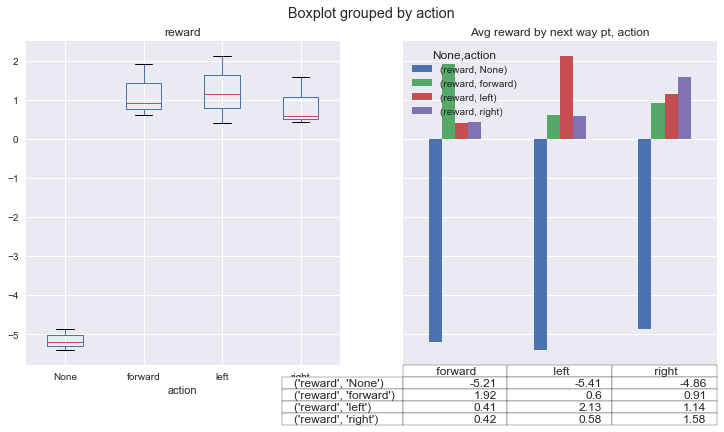

In [20]:
# example 1
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# sim_improved-learning.txt 
plt.close('defaultplot')

mycsv='sim_improved-qlearntbl.csv'
data1 = pd.read_csv(os.path.join("logs", mycsv))
mycsv='sim_improved-qlearntbl.2.csv'
data2 = pd.read_csv(os.path.join("logs", mycsv))

# The optimal policy: state1="light-state" 2="left-traffic" 3="oncoming-traffic" 4="next-waypoint"
filterstr='state1 == "green" & state2 == " notraffic" & state3 == " notraffic" ' 
sdata = data1.query( filterstr )
print( '-- In sim_improved-learning.txt, the optimal policy: Q-table filter criteria ->\n {}'.format(filterstr ))
print( '-- filtered result -->')
display( sdata )
sdata2= data2.query( filterstr )  # data format for graph

print('--> The Optimal Policy: Visual comparing reward by action, next way point' )
print('The given environment if is-green-light, no left traffic, no oncoming traffic')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=( 12, 6),  sharex=False, sharey=True)
ax1.get_xaxis().set_visible(True)
ax1.set_title( 'Reward by action' )
sdata2.boxplot( ax=ax1, column='reward', by='action' )

ax2.get_xaxis().set_visible(False)
ax2.set_title( 'Avg reward by next way pt, action' )
(sdata2.groupby(['state4', 'action']).mean().unstack().plot.bar( ax=ax2 , table=True))

plt.show()
plt.close()

>2.(continue...)  

>Example 2: If (1) is-green-light (2) left traffic - turn left (3) no oncoming traffic, <br>
Summary from the visualization for the optimal policy

>|state4<br>Next way point	| Action| policy evaluation |	Qvalue-Reward |
| :--- | :--- | :---- | :---- |
|if forward | forward |	suboptimal |	0.6 |
|if forward	| right |	suboptimal	| 0.58 |
|if forward	| no action/yield/wait | Incorrect | -5.41 |
|if forward	| left |	optimal?  not as expected |	2.13 |
|if left |	forward |	suboptimal |	0.91 |
|if left | right |	optimal?  not as expected| 1.58 |
|if left | no action/yield/wait | Incorrect | -4.86 |
|if left | left |	optimal |	1.14 |
|if right |	forward |	optimal?  not as expected  |	1.92 |
|if right | right |	suboptimal	| 0.42 |
|if right | no action/yield/wait | Incorrect | -5.21 |
|if right | left |	suboptimal |	0.41 |

>My observation from above result,  
This policy was not I expected, if next way point headed 'forward' direction, I would expect 'forward' as the optimal policy
- The best action was "left" which had the highest Qvalue-reward.  
- The worst action was "no action/yield" at green light and had the lowest Qvalue-reward.

>This policy was not I expected, if next way point turned 'left' direction, I would expect 'left' as the optimal policy 
- The best action was "right" and had the highest Qvalue-reward.  
- The worst action was "no action/yield" at green light and had the lowest Qvalue-reward. <br>

>This policy was not I expected,  if next way point turned 'right' direction,  I would expect 'right' as the optimal policy 
- The best action was "left" and had the highest Qvalue-reward.  
- The worst action was "no action/yield" at green light and had the lowest Qvalue-reward.

-- The optimal policy: Q-table filter criteria ->
 state1 == "green" & state2 == " notraffic" & state3 == " left" 
-- filtered result -->


,state1,state2,state3,state4,action1,reward1,action2,reward2,action3,reward3,action4,reward4
3,green,notraffic,left,forward,forward,2.15,right,0.45,None,-4.82,left,0.56
57,green,notraffic,left,left,forward,1.11,right,0.67,None,-4.89,left,1.28
76,green,notraffic,left,right,forward,0.87,right,1.53,None,-4.44,left,0.74


--> The Optimal Policy: Visual comparing reward by action, next way point
The given environment if is-green-light, left traffic-notraffic, oncoming traffic-turn left


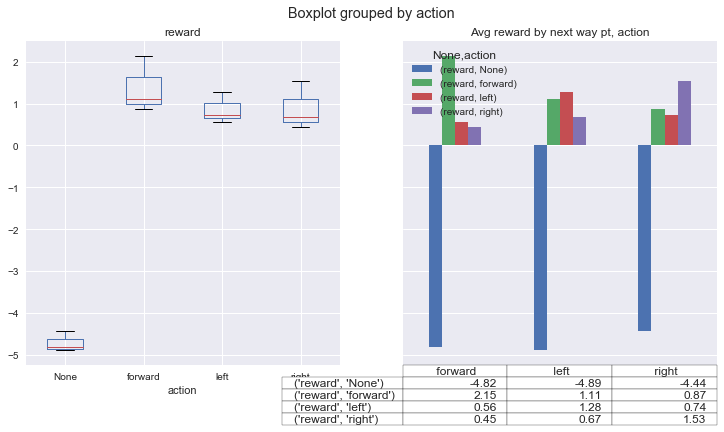

In [23]:
# example 2
plt.close('defaultplot')

# The optimal policy: state1="light-state" 2="left-traffic" 3="oncoming-traffic" 4="next-waypoint"
filterstr='state1 == "green" & state2 == " notraffic" & state3 == " left" ' 
sdata = data1.query( filterstr )
print( '-- The optimal policy: Q-table filter criteria ->\n {}'.format(filterstr ))
print( '-- filtered result -->')
display( sdata ) 
sdata2= data2.query( filterstr )  # data format for graph

print('--> The Optimal Policy: Visual comparing reward by action, next way point' )
print('The given environment if is-green-light, left traffic-notraffic, oncoming traffic-turn left')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=( 12, 6),  sharex=False, sharey=True)
ax1.get_xaxis().set_visible(True)
ax1.set_title( 'Reward by action' )
sdata2.boxplot( ax=ax1, column='reward', by='action' )

ax2.get_xaxis().set_visible(False)
ax2.set_title( 'Avg reward by next way pt, action' )
(sdata2.groupby(['state4', 'action']).mean().unstack().plot.bar( ax=ax2 , table=True))

plt.show()
plt.close()

>Example 3: If (1) is-red-light (2) next way point is not right  <br>
Summary from the visualization for the optimal policy 

>| left traffic | oncoming traffic | Action | policy evaluation |	Qvalue-Reward |
 | :---- | :---- | :-------- | ---- |
 | all direction |all direction | left | incorrect | negative reward |
 | all direction |all direction |forward | incorrect  |negative reward |
 | all direction |all direction |None |  optimal | positive reward |
 | all direction |all direction |right | suboptimal |  zero to negative reward |

>My observation from above result,  
This is correct policy, if next way point would turn left/forward (not right), the agent would wait/yield

>3.When simulation trial just started, I observed 3 / 6 (50%), which had violation count > 0 and negative rewards.  
- As trial runs increased, the observation decreased 4/15 (26%) which had negative rewards.  References and Additional Resources: 

>4.Try to find at least one entry where the smartcab did not learn the optimal policy. Discuss why your cab may have not learned the correct policy for the given state.

Conclusion:

>Overall, the learned policy provided better decision to the agent to make better action in later trials

>| Trial | Accident & Violation Count | Reward | Reliability | Exploration/Learning Factor | 
| --- | :------ | :--- | :------ | --- | 
| 150 | decreased to 25% | -4 | 75/40 % |
| 230 |  decrease to 15% |  -2  |  40/40 %    |
| 250 | decreased to 2-3% | increased to above 0 | range of 80 | 30/40 % |


-- The optimal policy: Q-table filter criteria ->
 state1 == "red" & state4 != " right"
--> The Optimal Policy: Visual comparing reward by action, next way point
The given environment if is-red-light, next way point-not right


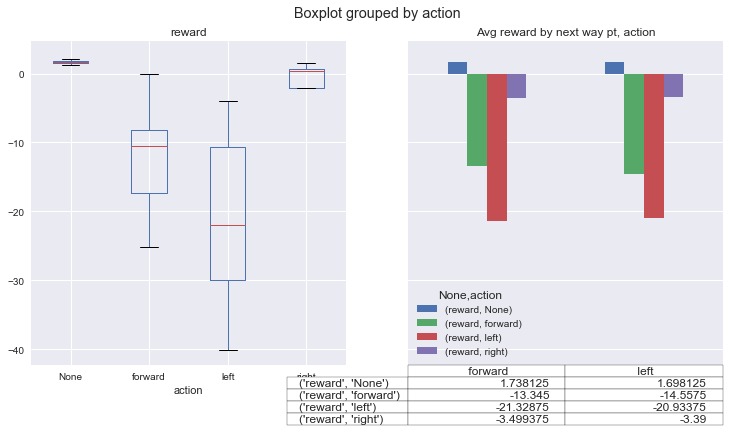

In [22]:
# example 3
plt.close('defaultplot')

# The optimal policy: state1="light-state" 2="left-traffic" 3="oncoming-traffic" 4="next-waypoint"
filterstr='state1 == "red" & state4 != " right"' 
sdata = data1.query( filterstr )
print( '-- The optimal policy: Q-table filter criteria ->\n {}'.format(filterstr ))
if verbos:
    print( '-- filtered result -->')
    display( sdata )
sdata2= data2.query( filterstr )  # data format for graph

print('--> The Optimal Policy: Visual comparing reward by action, next way point' )
print('The given environment if is-red-light, next way point-not right')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=( 12, 6),  sharex=False, sharey=True)
ax1.get_xaxis().set_visible(True)
ax1.set_title( 'Reward by action' )
sdata2.boxplot( ax=ax1, column='reward', by='action' )

ax2.get_xaxis().set_visible(False)
ax2.set_title( 'Avg reward by next way pt, action' )
(sdata2.groupby(['state4', 'action']).mean().unstack().plot.bar( ax=ax2 , table=True))

plt.show()
plt.close()

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. 
- One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. 
- Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

Notes from References:
- probability of an event= number of times event occurs/( total number of trails) 
- the epsilon ( the probability of an event should occur) 
- if we know the number of trails N then we can find number of times events should happen during N trails.
- true probability of an event = (number of favorable outcomes of event)/ (number of possible outcomes) .
if number of trails approaches to infinity.
- what is a probability that selected random-number is less than epsilon.
The answer is total numbers which are less that epsilon/ ( total numbers )

References and Additional Resources: 
- [A brief introduction to reinforcement learning by Kevin Murphy](http://www.cs.ubc.ca/~murphyk/Bayes/pomdp.html)
- [Gradient Descent For Machine Learning](https://machinelearningmastery.com/gradient-descent-for-machine-learning/)
- [How to implement epsilon greedy strategy / policy](https://junedmunshi.wordpress.com/tag/epsilon-policy/)
- [Machine Learning Nanodegree by udacity.com](https://classroom.udacity.com/nanodegrees/nd009/)
- [Machine Learning, part III: The Q-learning algorithm](https://articles.wearepop.com/secret-formula-for-self-learning-computers)
- [Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process)
- [Q-learning Tutorial](http://mnemstudio.org/path-finding-q-learning-tutorial.htm)
- [Q-learning](https://en.wikipedia.org/wiki/Q-learning)
- [Reinforcement learning in Scholarpedia](http://www.scholarpedia.org/article/Reinforcement_learning)
- [Reinforcement Learning](http://www.cse.unsw.edu.au/~cs9417ml/RL1/algorithms.html)
- [Reinforcement Learning](https://classroom.udacity.com/nanodegrees/nd009/parts/9777e610-ebeb-4c49-b502-88c692489ae3)
- [Simple Beginner’s guide to Reinforcement Learning & its implementation](https://www.analyticsvidhya.com/blog/2017/01/introduction-to-reinforcement-learning-implementation/)
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)